## Project Description 

This project was created for a data challenge [https://knowledgepit.ml/predicting-victories-in-video-games/]. The goal is to predict the winner in strategic video game - the Tactical Troops: Anthracite Shif. The alghoritm is supposed to analyse logits from multiplayer games. Each game is played by 2 players. 

What makes my solution unique, is that it uses Apriori alghoritm to check effectiveness of particular weapon or unit on a particular map. All retrieved and encoded information is put into neural network. I've also tried diffrent alghoritms as KNN-Classifier, but neural networks performs slighlty better.


Author: Adrianna Klank

## Dataset preparation 

In [ ]:
import pandas as pd
from sklearn import preprocessing
import numpy as np
from sklearn.model_selection import train_test_split
import keras
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder

In [ ]:
df = pd.read_csv('training_data_tabular_format.csv')
df = df.fillna('0')       # filling empty fields with 0 
df.head()

,id,winner,version,map_name,mode,t,turn_no,to_move,teams.0.0.unit_type,teams.0.0.dead,teams.0.0.current_ap,teams.0.0.current_hp,teams.0.0.armor.hp,teams.0.0.armor.id,teams.0.0.weapons_stats.0.id,teams.0.0.weapons_stats.0.cnt,teams.0.0.weapons_stats.1.id,teams.0.0.weapons_stats.1.cnt,teams.0.0.gadgets_stats.0.id,teams.0.0.gadgets_stats.0.cnt,teams.0.0.gadgets_stats.1.id,teams.0.0.gadgets_stats.1.cnt,teams.0.0.gadgets_stats.2.id,teams.0.0.gadgets_stats.2.cnt,teams.0.0.gadgets_stats.3.id,teams.0.0.gadgets_stats.3.cnt,teams.0.0.gadgets_stats.4.id,teams.0.0.gadgets_stats.4.cnt,teams.0.1.unit_type,teams.0.1.dead,teams.0.1.current_ap,teams.0.1.current_hp,teams.0.1.armor.hp,teams.0.1.armor.id,teams.0.1.weapons_stats.0.id,teams.0.1.weapons_stats.0.cnt,teams.0.1.weapons_stats.1.id,teams.0.1.weapons_stats.1.cnt,teams.0.1.gadgets_stats.0.id,teams.0.1.gadgets_stats.0.cnt,...,teams.1.3.gadgets_stats.0.id,teams.1.3.gadgets_stats.0.cnt,teams.1.3.gadgets_stats.1.id,teams.1.3.gadgets_stats.1.cnt,teams.1.3.gadgets_stats.2.id,teams.1.3.gadgets_stats.2.cnt,teams.1.3.gadgets_stats.3.id,teams.1.3.gadgets_stats.3.cnt,teams.1.3.gadgets_stats.4.id,teams.1.3.gadgets_stats.4.cnt,control_points.0.captured,control_points.0.owner,control_points.1.captured,control_points.1.owner,control_points.2.captured,control_points.2.owner,generators.0.0.dead,generators.0.0.hp,generators.0.1.dead,generators.0.1.hp,generators.0.2.dead,generators.0.2.hp,generators.0.3.dead,generators.0.3.hp,generators.0.4.dead,generators.0.4.hp,generators.1.0.dead,generators.1.0.hp,generators.1.1.dead,generators.1.1.hp,generators.1.2.dead,generators.1.2.hp,generators.1.3.dead,generators.1.3.hp,generators.1.4.dead,generators.1.4.hp,players.0.ai,players.0.player_id,players.1.ai,players.1.player_id
0,10001,1,0.9.2,Map05,Devastator,213.654861,12,0,unt03,1,100,0,0,0,wpn34,30,wpn32,28,min04,1,thrml01,1,sprnt01,1,0,0,0,0,unt04,0,50,70,0,0,wpn18,20,wpn13,0,adr01,2,...,flsh01,3,min01,3,shd03,2,stm01,1,0,0,0,0,0,0,0,0,0,100,0,28,1,0,0,100,0,100,0,100,0,100,0,100,1,0,0,100,1,player_00704323469,1,player_07953555124
1,10002,1,0.9.2,Map15,Devastator,226.890121,13,1,unt03,0,0,60,40,arm05,wpn20,40,wpn34,22,gnd01,1,thrml01,1,sprnt01,1,0,0,0,0,unt03,1,6,0,20,arm04,wpn27,30,wpn34,30,thrml01,1,...,adr01,2,med01,2,0,0,0,0,0,0,0,0,0,0,0,0,0,100,0,100,0,100,0,100,1,0,0,100,0,100,1,0,0,100,0,100,1,player_01860638195,1,player_06016939146
2,10004,1,0.9.2,Map01,Devastator,218.876938,10,0,unt03,1,4,0,0,arm01,wpn10,18,wpn12,35,gnd02,3,thrml01,1,sprnt01,1,0,0,0,0,unt03,0,4,60,50,arm02,wpn18,20,wpn02,15,gnd01,1,...,flsh01,3,mrt02,1,0,0,0,0,0,0,0,0,0,0,0,0,0,100,0,100,0,100,0,100,0,100,0,55,0,100,0,100,0,100,0,100,1,player_06016939146,1,player_01860638195
3,10008,1,0.10.1,Map13,Domination,146.658400,6,0,unt03,1,0,0,0,0,wpn28,50,wpn27,30,thrml01,1,sprnt01,1,0,0,0,0,0,0,unt02,0,100,140,0,0,wpn28,50,wpn20,40,btrRam01,3,...,gnd05,1,btrRam01,3,shd04,2,mrt02,1,0,0,0,1,0,-1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,player_04933395607,1,player_03967534028
4,10009,1,0.10.1,Map16,Domination,164.802048,6,0,unt03,0,0,60,35,arm01,wpn14,7,wpn17,16,min02,1,thrml01,1,sprnt01,1,stm03,1,0,0,unt02,0,2,140,0,0,wpn32,30,wpn12,50,btrRam01,3,...,adr01,2,med01,2,min02,1,stm02,0,stm05,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,player_03687477746,1,player_03946015325


There are 198 columns in the dataset, so I've decided to group them. It was necessery for further analysis and apriori. 

In [ ]:
def create_set(columns, df) -> set:
  """ E.g. return set of all the types of units """ 
  objects_lst = []
  for c in columns:
    objects_lst += list(df[c])
  return list(set(objects_lst))

In [ ]:
def create_list_of_columns1(key_word, df) -> list:
  """ for example creating list of columns with unit_type """
  return [c for c in df.columns if key_word in c.split('.')]

In [ ]:
def create_list_of_columns2(key_word, key_word2, df) -> list:
  """ for example creating list of columns with weapons_stats and id """
  return [c for c in df.columns if (key_word in c.split('.') and key_word2 in c.split('.'))]

In [ ]:
units_columns = create_list_of_columns1('unit_type', df)
weapons_columns = create_list_of_columns2('weapons_stats', 'id', df)
armor_columns = create_list_of_columns2('armor', 'id', df)
gadgets_columns = create_list_of_columns2('gadgets_stats', 'id', df)
hp_columns = create_list_of_columns1('hp', df)
hp_columns.extend(create_list_of_columns1('current_hp', df))
ap_columns = create_list_of_columns1('ap', df)
ap_columns.extend(create_list_of_columns1('current_ap', df))
maps_columns = ['map_name']
cp_columns = create_list_of_columns1('control_points', df)
generators_columns = create_list_of_columns1('generators', df)
dead_columns = create_list_of_columns1('dead', df)

In [ ]:
print(create_set(units_columns, df))

['unt04', 'unt03', 'unt01', 'unt02']


I've used another dataset for units description. My idea was to replaced health points with percents, because I thought it may improve performance of alghoritm. 

In [ ]:
df_units = pd.read_csv('units.csv')
df_units.head()

,Unnamed: 0,Ap,Hp,Id,Name,Perception,Description,Movementrange,Availableinbriefing,Reloadcostmultiplier,Throwforcemultiplier,Armormovementmultiplier,Overwatchanglemultiplier
0,3,100,60,unt03,Scout,1.25,NaN,8.0,True,1.00,1.0,1.25,1.0
1,5,100,70,unt04,Support,1.00,NaN,6.0,True,1.25,1.0,1.50,1.0
2,15,100,80,unt05,Captain,1.00,NaN,6.0,False,1.00,1.0,1.00,1.0
3,21,100,100,unt01,Assault,1.00,NaN,7.0,True,1.00,1.0,1.00,1.0
4,25,100,140,unt02,Heavy,0.75,NaN,6.0,True,1.25,1.0,0.50,1.0


In [ ]:
def find_full_hp(unit):
  for index, value in df_units.loc[df_units['Id']==unit].iterrows():
    return value['Hp']
for unit in create_set(units_columns, df):
  print(find_full_hp(unit))

70
60
100
140


In [ ]:
def replace_hp_percents(df):
  for unit in create_set(units_columns, df):
    df = df.replace(unit, find_full_hp(unit))

  units_hp_c = create_list_of_columns1('current_hp', df)
  #print(units_hp_c)
  for c in units_hp_c:
    unit_type_column = c[:10] + 'unit_type'
    df.loc[:, c] = df.loc[:, c].div(df[unit_type_column], axis=0)
  return df

In [ ]:
for unit in create_set(units_columns, df):
  df = df.replace(unit, find_full_hp(unit))
df.head()

,id,winner,version,map_name,mode,t,turn_no,to_move,teams.0.0.unit_type,teams.0.0.dead,teams.0.0.current_ap,teams.0.0.current_hp,teams.0.0.armor.hp,teams.0.0.armor.id,teams.0.0.weapons_stats.0.id,teams.0.0.weapons_stats.0.cnt,teams.0.0.weapons_stats.1.id,teams.0.0.weapons_stats.1.cnt,teams.0.0.gadgets_stats.0.id,teams.0.0.gadgets_stats.0.cnt,teams.0.0.gadgets_stats.1.id,teams.0.0.gadgets_stats.1.cnt,teams.0.0.gadgets_stats.2.id,teams.0.0.gadgets_stats.2.cnt,teams.0.0.gadgets_stats.3.id,teams.0.0.gadgets_stats.3.cnt,teams.0.0.gadgets_stats.4.id,teams.0.0.gadgets_stats.4.cnt,teams.0.1.unit_type,teams.0.1.dead,teams.0.1.current_ap,teams.0.1.current_hp,teams.0.1.armor.hp,teams.0.1.armor.id,teams.0.1.weapons_stats.0.id,teams.0.1.weapons_stats.0.cnt,teams.0.1.weapons_stats.1.id,teams.0.1.weapons_stats.1.cnt,teams.0.1.gadgets_stats.0.id,teams.0.1.gadgets_stats.0.cnt,...,teams.1.3.gadgets_stats.0.id,teams.1.3.gadgets_stats.0.cnt,teams.1.3.gadgets_stats.1.id,teams.1.3.gadgets_stats.1.cnt,teams.1.3.gadgets_stats.2.id,teams.1.3.gadgets_stats.2.cnt,teams.1.3.gadgets_stats.3.id,teams.1.3.gadgets_stats.3.cnt,teams.1.3.gadgets_stats.4.id,teams.1.3.gadgets_stats.4.cnt,control_points.0.captured,control_points.0.owner,control_points.1.captured,control_points.1.owner,control_points.2.captured,control_points.2.owner,generators.0.0.dead,generators.0.0.hp,generators.0.1.dead,generators.0.1.hp,generators.0.2.dead,generators.0.2.hp,generators.0.3.dead,generators.0.3.hp,generators.0.4.dead,generators.0.4.hp,generators.1.0.dead,generators.1.0.hp,generators.1.1.dead,generators.1.1.hp,generators.1.2.dead,generators.1.2.hp,generators.1.3.dead,generators.1.3.hp,generators.1.4.dead,generators.1.4.hp,players.0.ai,players.0.player_id,players.1.ai,players.1.player_id
0,10001,1,0.9.2,Map05,Devastator,213.654861,12,0,60,1,100,0,0,0,wpn34,30,wpn32,28,min04,1,thrml01,1,sprnt01,1,0,0,0,0,70,0,50,70,0,0,wpn18,20,wpn13,0,adr01,2,...,flsh01,3,min01,3,shd03,2,stm01,1,0,0,0,0,0,0,0,0,0,100,0,28,1,0,0,100,0,100,0,100,0,100,0,100,1,0,0,100,1,player_00704323469,1,player_07953555124
1,10002,1,0.9.2,Map15,Devastator,226.890121,13,1,60,0,0,60,40,arm05,wpn20,40,wpn34,22,gnd01,1,thrml01,1,sprnt01,1,0,0,0,0,60,1,6,0,20,arm04,wpn27,30,wpn34,30,thrml01,1,...,adr01,2,med01,2,0,0,0,0,0,0,0,0,0,0,0,0,0,100,0,100,0,100,0,100,1,0,0,100,0,100,1,0,0,100,0,100,1,player_01860638195,1,player_06016939146
2,10004,1,0.9.2,Map01,Devastator,218.876938,10,0,60,1,4,0,0,arm01,wpn10,18,wpn12,35,gnd02,3,thrml01,1,sprnt01,1,0,0,0,0,60,0,4,60,50,arm02,wpn18,20,wpn02,15,gnd01,1,...,flsh01,3,mrt02,1,0,0,0,0,0,0,0,0,0,0,0,0,0,100,0,100,0,100,0,100,0,100,0,55,0,100,0,100,0,100,0,100,1,player_06016939146,1,player_01860638195
3,10008,1,0.10.1,Map13,Domination,146.658400,6,0,60,1,0,0,0,0,wpn28,50,wpn27,30,thrml01,1,sprnt01,1,0,0,0,0,0,0,140,0,100,140,0,0,wpn28,50,wpn20,40,btrRam01,3,...,gnd05,1,btrRam01,3,shd04,2,mrt02,1,0,0,0,1,0,-1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,player_04933395607,1,player_03967534028
4,10009,1,0.10.1,Map16,Domination,164.802048,6,0,60,0,0,60,35,arm01,wpn14,7,wpn17,16,min02,1,thrml01,1,sprnt01,1,stm03,1,0,0,140,0,2,140,0,0,wpn32,30,wpn12,50,btrRam01,3,...,adr01,2,med01,2,min02,1,stm02,0,stm05,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,player_03687477746,1,player_03946015325


In [ ]:
units_hp_c = create_list_of_columns1('current_hp', df)
print(units_hp_c)

for c in units_hp_c:
  unit_type_column = c[:10] + 'unit_type'
  df.loc[:, c] = df.loc[:, c].div(df[unit_type_column], axis=0)
  
df.head()

['teams.0.0.current_hp', 'teams.0.1.current_hp', 'teams.0.2.current_hp', 'teams.0.3.current_hp', 'teams.1.0.current_hp', 'teams.1.1.current_hp', 'teams.1.2.current_hp', 'teams.1.3.current_hp']


,id,winner,version,map_name,mode,t,turn_no,to_move,teams.0.0.unit_type,teams.0.0.dead,teams.0.0.current_ap,teams.0.0.current_hp,teams.0.0.armor.hp,teams.0.0.armor.id,teams.0.0.weapons_stats.0.id,teams.0.0.weapons_stats.0.cnt,teams.0.0.weapons_stats.1.id,teams.0.0.weapons_stats.1.cnt,teams.0.0.gadgets_stats.0.id,teams.0.0.gadgets_stats.0.cnt,teams.0.0.gadgets_stats.1.id,teams.0.0.gadgets_stats.1.cnt,teams.0.0.gadgets_stats.2.id,teams.0.0.gadgets_stats.2.cnt,teams.0.0.gadgets_stats.3.id,teams.0.0.gadgets_stats.3.cnt,teams.0.0.gadgets_stats.4.id,teams.0.0.gadgets_stats.4.cnt,teams.0.1.unit_type,teams.0.1.dead,teams.0.1.current_ap,teams.0.1.current_hp,teams.0.1.armor.hp,teams.0.1.armor.id,teams.0.1.weapons_stats.0.id,teams.0.1.weapons_stats.0.cnt,teams.0.1.weapons_stats.1.id,teams.0.1.weapons_stats.1.cnt,teams.0.1.gadgets_stats.0.id,teams.0.1.gadgets_stats.0.cnt,...,teams.1.3.gadgets_stats.0.id,teams.1.3.gadgets_stats.0.cnt,teams.1.3.gadgets_stats.1.id,teams.1.3.gadgets_stats.1.cnt,teams.1.3.gadgets_stats.2.id,teams.1.3.gadgets_stats.2.cnt,teams.1.3.gadgets_stats.3.id,teams.1.3.gadgets_stats.3.cnt,teams.1.3.gadgets_stats.4.id,teams.1.3.gadgets_stats.4.cnt,control_points.0.captured,control_points.0.owner,control_points.1.captured,control_points.1.owner,control_points.2.captured,control_points.2.owner,generators.0.0.dead,generators.0.0.hp,generators.0.1.dead,generators.0.1.hp,generators.0.2.dead,generators.0.2.hp,generators.0.3.dead,generators.0.3.hp,generators.0.4.dead,generators.0.4.hp,generators.1.0.dead,generators.1.0.hp,generators.1.1.dead,generators.1.1.hp,generators.1.2.dead,generators.1.2.hp,generators.1.3.dead,generators.1.3.hp,generators.1.4.dead,generators.1.4.hp,players.0.ai,players.0.player_id,players.1.ai,players.1.player_id
0,10001,1,0.9.2,Map05,Devastator,213.654861,12,0,60,1,100,0.0,0,0,wpn34,30,wpn32,28,min04,1,thrml01,1,sprnt01,1,0,0,0,0,70,0,50,1.0,0,0,wpn18,20,wpn13,0,adr01,2,...,flsh01,3,min01,3,shd03,2,stm01,1,0,0,0,0,0,0,0,0,0,100,0,28,1,0,0,100,0,100,0,100,0,100,0,100,1,0,0,100,1,player_00704323469,1,player_07953555124
1,10002,1,0.9.2,Map15,Devastator,226.890121,13,1,60,0,0,1.0,40,arm05,wpn20,40,wpn34,22,gnd01,1,thrml01,1,sprnt01,1,0,0,0,0,60,1,6,0.0,20,arm04,wpn27,30,wpn34,30,thrml01,1,...,adr01,2,med01,2,0,0,0,0,0,0,0,0,0,0,0,0,0,100,0,100,0,100,0,100,1,0,0,100,0,100,1,0,0,100,0,100,1,player_01860638195,1,player_06016939146
2,10004,1,0.9.2,Map01,Devastator,218.876938,10,0,60,1,4,0.0,0,arm01,wpn10,18,wpn12,35,gnd02,3,thrml01,1,sprnt01,1,0,0,0,0,60,0,4,1.0,50,arm02,wpn18,20,wpn02,15,gnd01,1,...,flsh01,3,mrt02,1,0,0,0,0,0,0,0,0,0,0,0,0,0,100,0,100,0,100,0,100,0,100,0,55,0,100,0,100,0,100,0,100,1,player_06016939146,1,player_01860638195
3,10008,1,0.10.1,Map13,Domination,146.658400,6,0,60,1,0,0.0,0,0,wpn28,50,wpn27,30,thrml01,1,sprnt01,1,0,0,0,0,0,0,140,0,100,1.0,0,0,wpn28,50,wpn20,40,btrRam01,3,...,gnd05,1,btrRam01,3,shd04,2,mrt02,1,0,0,0,1,0,-1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,player_04933395607,1,player_03967534028
4,10009,1,0.10.1,Map16,Domination,164.802048,6,0,60,0,0,1.0,35,arm01,wpn14,7,wpn17,16,min02,1,thrml01,1,sprnt01,1,stm03,1,0,0,140,0,2,1.0,0,0,wpn32,30,wpn12,50,btrRam01,3,...,adr01,2,med01,2,min02,1,stm02,0,stm05,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,player_03687477746,1,player_03946015325


## Encoding

All the columns with string data must be encoded 

In [ ]:
def encode(columns, df) -> df:
  df_copy = df.copy()
  # labels = [df[c] for c in columns]
  labels = create_set(columns, df)
  labels = np.array(np.reshape(labels, (-1, 1)))
  le = preprocessing.OrdinalEncoder()
  encoded = le.fit_transform(labels)
  for i in range(labels.shape[0]):
    df_copy = df_copy.replace(to_replace=labels[i], value=encoded[i])
  return df_copy

In [ ]:
to_encode = [units_columns, weapons_columns, armor_columns, gadgets_columns, maps_columns]
df_encoded = df.copy()
for c in to_encode:
  df_encoded = encode(c, df_encoded)
df_encoded.head()

,id,winner,version,map_name,mode,t,turn_no,to_move,teams.0.0.unit_type,teams.0.0.dead,teams.0.0.current_ap,teams.0.0.current_hp,teams.0.0.armor.hp,teams.0.0.armor.id,teams.0.0.weapons_stats.0.id,teams.0.0.weapons_stats.0.cnt,teams.0.0.weapons_stats.1.id,teams.0.0.weapons_stats.1.cnt,teams.0.0.gadgets_stats.0.id,teams.0.0.gadgets_stats.0.cnt,teams.0.0.gadgets_stats.1.id,teams.0.0.gadgets_stats.1.cnt,teams.0.0.gadgets_stats.2.id,teams.0.0.gadgets_stats.2.cnt,teams.0.0.gadgets_stats.3.id,teams.0.0.gadgets_stats.3.cnt,teams.0.0.gadgets_stats.4.id,teams.0.0.gadgets_stats.4.cnt,teams.0.1.unit_type,teams.0.1.dead,teams.0.1.current_ap,teams.0.1.current_hp,teams.0.1.armor.hp,teams.0.1.armor.id,teams.0.1.weapons_stats.0.id,teams.0.1.weapons_stats.0.cnt,teams.0.1.weapons_stats.1.id,teams.0.1.weapons_stats.1.cnt,teams.0.1.gadgets_stats.0.id,teams.0.1.gadgets_stats.0.cnt,...,teams.1.3.gadgets_stats.0.id,teams.1.3.gadgets_stats.0.cnt,teams.1.3.gadgets_stats.1.id,teams.1.3.gadgets_stats.1.cnt,teams.1.3.gadgets_stats.2.id,teams.1.3.gadgets_stats.2.cnt,teams.1.3.gadgets_stats.3.id,teams.1.3.gadgets_stats.3.cnt,teams.1.3.gadgets_stats.4.id,teams.1.3.gadgets_stats.4.cnt,control_points.0.captured,control_points.0.owner,control_points.1.captured,control_points.1.owner,control_points.2.captured,control_points.2.owner,generators.0.0.dead,generators.0.0.hp,generators.0.1.dead,generators.0.1.hp,generators.0.2.dead,generators.0.2.hp,generators.0.3.dead,generators.0.3.hp,generators.0.4.dead,generators.0.4.hp,generators.1.0.dead,generators.1.0.hp,generators.1.1.dead,generators.1.1.hp,generators.1.2.dead,generators.1.2.hp,generators.1.3.dead,generators.1.3.hp,generators.1.4.dead,generators.1.4.hp,players.0.ai,players.0.player_id,players.1.ai,players.1.player_id
0,10001.0,1.0,0.9.2,4.0,Devastator,213.654861,12.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,32.0,30.0,30.0,28.0,14.0,1.0,30.0,1.0,24.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,50.0,1.0,0.0,0.0,16.0,20.0,11.0,0.0,1.0,2.0,...,5.0,3.0,11.0,3.0,20.0,2.0,25.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,28.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,1.0,0.0,0.0,2.0,1.0,player_00704323469,1.0,player_07953555124
1,10002.0,1.0,0.9.2,14.0,Devastator,226.890121,13.0,1.0,0.0,0.0,0.0,1.0,40.0,5.0,18.0,40.0,32.0,22.0,6.0,1.0,30.0,1.0,24.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,0.0,20.0,4.0,25.0,30.0,32.0,30.0,30.0,1.0,...,1.0,2.0,10.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,1.0,0.0,0.0,2.0,0.0,2.0,1.0,0.0,0.0,2.0,0.0,2.0,1.0,player_01860638195,1.0,player_06016939146
2,10004.0,1.0,0.9.2,0.0,Devastator,218.876938,10.0,0.0,0.0,1.0,4.0,0.0,0.0,1.0,8.0,18.0,10.0,35.0,7.0,3.0,30.0,1.0,24.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,50.0,2.0,16.0,20.0,2.0,15.0,6.0,1.0,...,5.0,3.0,16.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,55.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,1.0,player_06016939146,1.0,player_01860638195
3,10008.0,1.0,0.10.1,12.0,Domination,146.658400,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,26.0,50.0,25.0,30.0,30.0,1.0,24.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,2.0,1.0,0.0,0.0,26.0,50.0,18.0,40.0,2.0,3.0,...,9.0,1.0,2.0,3.0,21.0,2.0,16.0,1.0,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,player_04933395607,1.0,player_03967534028
4,10009.0,1.0,0.10.1,15.0,Domination,164.802048,6.0,0.0,0.0,0.0,0.0,1.0,35.0,1.0,12.0,7.0,15.0,16.0,12.0,1.0,30.0,1.0,24.0,1.0,27.0,1.0,0.0,0.0,3.0,0.0,2.0,1.0,0.0,0.0,30.0,30.0,10.0,50.0,2.0,3.0,...,1.0,2.0,10.0,2.0,12.0,1.0,26.0,0.0,29.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,player_03687477746,1.0,player_03946015325


## Effectiveness

Below cells are needed for computing effectiveness with apriori. 

In [ ]:
columns_to_insert = ['all_weapons.0', 'all_weapons.1', 'all_units.0', 'all_units.1', 'all_gadgets.0', 'all_gadgets.1', 'all_armors.0', 'all_armors.1']
# in each column there will be list of all e.g. weapons used by team 0 or 1 and number 999 if team has won 
df_with_columns = df_encoded.copy()
for column in columns_to_insert:
  df_with_columns.insert(df_with_columns.shape[1], column, [[] for i in range(df_with_columns.shape[0])])
#for now all the lists are empty 
df_with_columns.head()

,id,winner,version,map_name,mode,t,turn_no,to_move,teams.0.0.unit_type,teams.0.0.dead,teams.0.0.current_ap,teams.0.0.current_hp,teams.0.0.armor.hp,teams.0.0.armor.id,teams.0.0.weapons_stats.0.id,teams.0.0.weapons_stats.0.cnt,teams.0.0.weapons_stats.1.id,teams.0.0.weapons_stats.1.cnt,teams.0.0.gadgets_stats.0.id,teams.0.0.gadgets_stats.0.cnt,teams.0.0.gadgets_stats.1.id,teams.0.0.gadgets_stats.1.cnt,teams.0.0.gadgets_stats.2.id,teams.0.0.gadgets_stats.2.cnt,teams.0.0.gadgets_stats.3.id,teams.0.0.gadgets_stats.3.cnt,teams.0.0.gadgets_stats.4.id,teams.0.0.gadgets_stats.4.cnt,teams.0.1.unit_type,teams.0.1.dead,teams.0.1.current_ap,teams.0.1.current_hp,teams.0.1.armor.hp,teams.0.1.armor.id,teams.0.1.weapons_stats.0.id,teams.0.1.weapons_stats.0.cnt,teams.0.1.weapons_stats.1.id,teams.0.1.weapons_stats.1.cnt,teams.0.1.gadgets_stats.0.id,teams.0.1.gadgets_stats.0.cnt,...,teams.1.3.gadgets_stats.4.id,teams.1.3.gadgets_stats.4.cnt,control_points.0.captured,control_points.0.owner,control_points.1.captured,control_points.1.owner,control_points.2.captured,control_points.2.owner,generators.0.0.dead,generators.0.0.hp,generators.0.1.dead,generators.0.1.hp,generators.0.2.dead,generators.0.2.hp,generators.0.3.dead,generators.0.3.hp,generators.0.4.dead,generators.0.4.hp,generators.1.0.dead,generators.1.0.hp,generators.1.1.dead,generators.1.1.hp,generators.1.2.dead,generators.1.2.hp,generators.1.3.dead,generators.1.3.hp,generators.1.4.dead,generators.1.4.hp,players.0.ai,players.0.player_id,players.1.ai,players.1.player_id,all_weapons.0,all_weapons.1,all_units.0,all_units.1,all_gadgets.0,all_gadgets.1,all_armors.0,all_armors.1
0,10001.0,1.0,0.9.2,4.0,Devastator,213.654861,12.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,32.0,30.0,30.0,28.0,14.0,1.0,30.0,1.0,24.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,50.0,1.0,0.0,0.0,16.0,20.0,11.0,0.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,28.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,1.0,0.0,0.0,2.0,1.0,player_00704323469,1.0,player_07953555124,[],[],[],[],[],[],[],[]
1,10002.0,1.0,0.9.2,14.0,Devastator,226.890121,13.0,1.0,0.0,0.0,0.0,1.0,40.0,5.0,18.0,40.0,32.0,22.0,6.0,1.0,30.0,1.0,24.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,0.0,20.0,4.0,25.0,30.0,32.0,30.0,30.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,1.0,0.0,0.0,2.0,0.0,2.0,1.0,0.0,0.0,2.0,0.0,2.0,1.0,player_01860638195,1.0,player_06016939146,[],[],[],[],[],[],[],[]
2,10004.0,1.0,0.9.2,0.0,Devastator,218.876938,10.0,0.0,0.0,1.0,4.0,0.0,0.0,1.0,8.0,18.0,10.0,35.0,7.0,3.0,30.0,1.0,24.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,50.0,2.0,16.0,20.0,2.0,15.0,6.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,55.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,1.0,player_06016939146,1.0,player_01860638195,[],[],[],[],[],[],[],[]
3,10008.0,1.0,0.10.1,12.0,Domination,146.658400,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,26.0,50.0,25.0,30.0,30.0,1.0,24.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,2.0,1.0,0.0,0.0,26.0,50.0,18.0,40.0,2.0,3.0,...,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,player_04933395607,1.0,player_03967534028,[],[],[],[],[],[],[],[]
4,10009.0,1.0,0.10.1,15.0,Domination,164.802048,6.0,0.0,0.0,0.0,0.0,1.0,35.0,1.0,12.0,7.0,15.0,16.0,12.0,1.0,30.0,1.0,24.0,1.0,27.0,1.0,0.0,0.0,3.0,0.0,2.0,1.0,0.0,0.0,30.0,30.0,10.0,50.0,2.0,3.0,...,29.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,player_03687477746,1.0,player_03946015325,[],[],[],[],[],[],[],[]


In [ ]:
def divide_columns_by_teams(columns) -> dict:
  columns_dict = {'0':[], '1':[]}
  columns_dict['0'] = [c for c in columns if c.split('.')[1]=='0']
  columns_dict['1'] = [c for c in columns if c.split('.')[1]=='1']
  return columns_dict

In [ ]:
def fill_columns(column0, column1, columns_dict, df) -> df:
  """
  e.g. column0 = 'all_weapons.0', columns_dict = weapons_columns
  create one set for a team, instead of a singular object for each team's unit
  """
  for index, row in df.iterrows():
    for column in columns_dict['0']:  
      row[column0].append(row[column])
    for column in columns_dict['1']: 
      row[column1].append(row[column]) 
    if row['winner'] == 1:
      row[column1].append(999)
    else:
      row[column0].append(999)
  return df

In [ ]:
df_filled = df_with_columns.copy()
df_filled = fill_columns('all_weapons.0', 'all_weapons.1', divide_columns_by_teams(weapons_columns), df_filled)
df_filled = fill_columns('all_units.0', 'all_units.1', divide_columns_by_teams(units_columns), df_filled)
df_filled = fill_columns('all_gadgets.0', 'all_gadgets.1', divide_columns_by_teams(gadgets_columns), df_filled)
df_filled = fill_columns('all_armors.0', 'all_armors.1', divide_columns_by_teams(armor_columns), df_filled)
df_filled.head()

,id,winner,version,map_name,mode,t,turn_no,to_move,teams.0.0.unit_type,teams.0.0.dead,teams.0.0.current_ap,teams.0.0.current_hp,teams.0.0.armor.hp,teams.0.0.armor.id,teams.0.0.weapons_stats.0.id,teams.0.0.weapons_stats.0.cnt,teams.0.0.weapons_stats.1.id,teams.0.0.weapons_stats.1.cnt,teams.0.0.gadgets_stats.0.id,teams.0.0.gadgets_stats.0.cnt,teams.0.0.gadgets_stats.1.id,teams.0.0.gadgets_stats.1.cnt,teams.0.0.gadgets_stats.2.id,teams.0.0.gadgets_stats.2.cnt,teams.0.0.gadgets_stats.3.id,teams.0.0.gadgets_stats.3.cnt,teams.0.0.gadgets_stats.4.id,teams.0.0.gadgets_stats.4.cnt,teams.0.1.unit_type,teams.0.1.dead,teams.0.1.current_ap,teams.0.1.current_hp,teams.0.1.armor.hp,teams.0.1.armor.id,teams.0.1.weapons_stats.0.id,teams.0.1.weapons_stats.0.cnt,teams.0.1.weapons_stats.1.id,teams.0.1.weapons_stats.1.cnt,teams.0.1.gadgets_stats.0.id,teams.0.1.gadgets_stats.0.cnt,...,teams.1.3.gadgets_stats.4.id,teams.1.3.gadgets_stats.4.cnt,control_points.0.captured,control_points.0.owner,control_points.1.captured,control_points.1.owner,control_points.2.captured,control_points.2.owner,generators.0.0.dead,generators.0.0.hp,generators.0.1.dead,generators.0.1.hp,generators.0.2.dead,generators.0.2.hp,generators.0.3.dead,generators.0.3.hp,generators.0.4.dead,generators.0.4.hp,generators.1.0.dead,generators.1.0.hp,generators.1.1.dead,generators.1.1.hp,generators.1.2.dead,generators.1.2.hp,generators.1.3.dead,generators.1.3.hp,generators.1.4.dead,generators.1.4.hp,players.0.ai,players.0.player_id,players.1.ai,players.1.player_id,all_weapons.0,all_weapons.1,all_units.0,all_units.1,all_gadgets.0,all_gadgets.1,all_armors.0,all_armors.1
0,10001.0,1.0,0.9.2,4.0,Devastator,213.654861,12.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,32.0,30.0,30.0,28.0,14.0,1.0,30.0,1.0,24.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,50.0,1.0,0.0,0.0,16.0,20.0,11.0,0.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,28.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,1.0,0.0,0.0,2.0,1.0,player_00704323469,1.0,player_07953555124,"[32.0, 30.0, 16.0, 11.0, 7.0, 13.0, 1.0, 24.0]","[27.0, 10.0, 18.0, 2.0, 31.0, 2.0, 16.0, 5.0, ...","[0.0, 1.0, 2.0, 1.0]","[1.0, 3.0, 0.0, 2.0, 999]","[14.0, 30.0, 24.0, 0.0, 0.0, 1.0, 10.0, 21.0, ...","[1.0, 10.0, 0.0, 0.0, 0.0, 2.0, 19.0, 0.0, 0.0...","[0.0, 0.0, 6.0, 0.0]","[0.0, 4.0, 0.0, 0.0, 999]"
1,10002.0,1.0,0.9.2,14.0,Devastator,226.890121,13.0,1.0,0.0,0.0,0.0,1.0,40.0,5.0,18.0,40.0,32.0,22.0,6.0,1.0,30.0,1.0,24.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,0.0,20.0,4.0,25.0,30.0,32.0,30.0,30.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,1.0,0.0,0.0,2.0,0.0,2.0,1.0,0.0,0.0,2.0,0.0,2.0,1.0,player_01860638195,1.0,player_06016939146,"[18.0, 32.0, 25.0, 32.0, 32.0, 27.0, 18.0, 7.0]","[8.0, 22.0, 10.0, 19.0, 13.0, 25.0, 23.0, 21.0...","[0.0, 0.0, 0.0, 0.0]","[0.0, 3.0, 3.0, 1.0, 999]","[6.0, 30.0, 24.0, 0.0, 0.0, 30.0, 24.0, 27.0, ...","[30.0, 24.0, 19.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0....","[5.0, 4.0, 4.0, 0.0]","[4.0, 0.0, 0.0, 5.0, 999]"
2,10004.0,1.0,0.9.2,0.0,Devastator,218.876938,10.0,0.0,0.0,1.0,4.0,0.0,0.0,1.0,8.0,18.0,10.0,35.0,7.0,3.0,30.0,1.0,24.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,50.0,2.0,16.0,20.0,2.0,15.0,6.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,55.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,1.0,player_06016939146,1.0,player_01860638195,"[8.0, 10.0, 16.0, 2.0, 13.0, 30.0, 26.0, 19.0]","[32.0, 7.0, 1.0, 26.0, 25.0, 26.0, 26.0, 1.0, ...","[0.0, 0.0, 1.0, 3.0]","[2.0, 1.0, 3.0, 2.0, 999]","[7.0, 30.0, 24.0, 0.0, 0.0, 6.0, 30.0, 24.0, 0...","[5.0, 0.0, 0.0, 0.0, 0.0, 1.0, 10.0, 6.0, 7.0,...","[1.0, 2.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 999]"
3,10008.0,1.0,0.10.1,12.0,Domination,146.658400,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,26.0,50.0,25.0,30.0,30.0,1.0,24.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,2.0,1.0,0.0,0.0,26.0,50.0,18.0,40.0,2.0,3.0,...,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,player_04933395607,1.0,player_03967534028,"[26.0, 25.0, 26.

In [ ]:
def compute_effectiveness(sets, max_len) -> df:
  encoder = TransactionEncoder().fit(sets)
  onehot = encoder.transform(sets)
  onehot = pd.DataFrame(onehot, columns=encoder.columns_)
  frequent_sets = apriori(onehot, min_support = 0.001, max_len=max_len, use_colnames=True)
  rules = association_rules(frequent_sets, metric="lift")
  rules = rules.sort_values(by='confidence', ascending=False)           #compute association rules and sort them by confidence
  effectiveness = rules.loc[rules['consequents']==frozenset({999})]   #take only the ones that imply winning 
  return effectiveness

In [ ]:
def compute_eff_by_map(column0, column1, max_len, df) -> dict:
  """ e.g. column 0 = 'all_weapons.0' column1 = 'all_weapons.1' """ 
  eff_dict = {}
  for map in create_set(maps_columns, df_filled):
    df_1_map = df.loc[df['map_name'] == map]
    sets = df_1_map[column0]+df_1_map[column1]
    eff_dict[map] = compute_effectiveness(df_1_map[column0].append(df_1_map[column1]), max_len)
  return eff_dict

In [ ]:
weapons_effectiveness = compute_eff_by_map('all_weapons.0', 'all_weapons.1', 2, df_filled)
gadgets_effectiveness = compute_eff_by_map('all_gadgets.0', 'all_gadgets.1', 2, df_filled)
armors_effectiveness = compute_eff_by_map('all_armors.0', 'all_armors.1', 2, df_filled)
#units_effectiveness = compute_eff_by_map('all_units.0', 'all_units.1', 2, df_filled)

In [ ]:
def fill_eff(df, eff_dict, columns):
  for map in create_set(maps_columns, df_filled):
    effectiveness = eff_dict[map]
    for index, value in effectiveness.iterrows():
      obj = next(iter(value['antecedents']))
      conf = value['confidence']
      df[columns] = df[columns].replace(obj, conf)
  return df

In [ ]:
def fill_eff_for_units(df, eff_dict, columns):
  for map in create_set(maps_columns, df_filled):
    effectiveness = eff_dict[map]
    for index, value in effectiveness.iterrows():
      obj = value['antecedents']
      conf = value['confidence']
      df[columns] = df[columns].replace(obj, conf)
  return df

In [ ]:
df_with_eff = df_filled.copy()
df_with_eff = fill_eff(df_with_eff, weapons_effectiveness, weapons_columns)
df_with_eff = fill_eff(df_with_eff, gadgets_effectiveness, gadgets_columns)
df_with_eff = fill_eff(df_with_eff, armors_effectiveness, armor_columns)
#df_with_eff = fill_eff(df_with_eff, units_effectiveness, units_columns)
#df_with_eff = fill_eff_for_units(df_with_eff, units_effectiveness, ['all_units.0', 'all_units.1'])
df_with_eff.head()

,id,winner,version,map_name,mode,t,turn_no,to_move,teams.0.0.unit_type,teams.0.0.dead,teams.0.0.current_ap,teams.0.0.current_hp,teams.0.0.armor.hp,teams.0.0.armor.id,teams.0.0.weapons_stats.0.id,teams.0.0.weapons_stats.0.cnt,teams.0.0.weapons_stats.1.id,teams.0.0.weapons_stats.1.cnt,teams.0.0.gadgets_stats.0.id,teams.0.0.gadgets_stats.0.cnt,teams.0.0.gadgets_stats.1.id,teams.0.0.gadgets_stats.1.cnt,teams.0.0.gadgets_stats.2.id,teams.0.0.gadgets_stats.2.cnt,teams.0.0.gadgets_stats.3.id,teams.0.0.gadgets_stats.3.cnt,teams.0.0.gadgets_stats.4.id,teams.0.0.gadgets_stats.4.cnt,teams.0.1.unit_type,teams.0.1.dead,teams.0.1.current_ap,teams.0.1.current_hp,teams.0.1.armor.hp,teams.0.1.armor.id,teams.0.1.weapons_stats.0.id,teams.0.1.weapons_stats.0.cnt,teams.0.1.weapons_stats.1.id,teams.0.1.weapons_stats.1.cnt,teams.0.1.gadgets_stats.0.id,teams.0.1.gadgets_stats.0.cnt,...,teams.1.3.gadgets_stats.4.id,teams.1.3.gadgets_stats.4.cnt,control_points.0.captured,control_points.0.owner,control_points.1.captured,control_points.1.owner,control_points.2.captured,control_points.2.owner,generators.0.0.dead,generators.0.0.hp,generators.0.1.dead,generators.0.1.hp,generators.0.2.dead,generators.0.2.hp,generators.0.3.dead,generators.0.3.hp,generators.0.4.dead,generators.0.4.hp,generators.1.0.dead,generators.1.0.hp,generators.1.1.dead,generators.1.1.hp,generators.1.2.dead,generators.1.2.hp,generators.1.3.dead,generators.1.3.hp,generators.1.4.dead,generators.1.4.hp,players.0.ai,players.0.player_id,players.1.ai,players.1.player_id,all_weapons.0,all_weapons.1,all_units.0,all_units.1,all_gadgets.0,all_gadgets.1,all_armors.0,all_armors.1
0,10001.0,1.0,0.9.2,4.0,Devastator,213.654861,12.0,0.0,0.0,1.0,2.0,0.0,0.0,0.498496,0.512644,30.0,0.588339,28.0,0.490598,1.0,0.481514,1.0,0.481514,1.0,0.500145,0.0,0.500145,0.0,1.0,0.0,50.0,1.0,0.0,0.498496,0.524501,20.0,0.501667,0.0,0.479104,2.0,...,0.500145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,28.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,1.0,0.0,0.0,2.0,1.0,player_00704323469,1.0,player_07953555124,"[32.0, 30.0, 16.0, 11.0, 7.0, 13.0, 1.0, 24.0]","[27.0, 10.0, 18.0, 2.0, 31.0, 2.0, 16.0, 5.0, ...","[0.0, 1.0, 2.0, 1.0]","[1.0, 3.0, 0.0, 2.0, 999]","[14.0, 30.0, 24.0, 0.0, 0.0, 1.0, 10.0, 21.0, ...","[1.0, 10.0, 0.0, 0.0, 0.0, 2.0, 19.0, 0.0, 0.0...","[0.0, 0.0, 6.0, 0.0]","[0.0, 4.0, 0.0, 0.0, 999]"
1,10002.0,1.0,0.9.2,14.0,Devastator,226.890121,13.0,1.0,0.0,0.0,0.0,1.0,40.0,0.509259,0.518519,40.0,0.512644,22.0,0.550891,1.0,0.481514,1.0,0.481514,1.0,0.500145,0.0,0.500145,0.0,0.0,1.0,6.0,0.0,20.0,0.511312,0.532333,30.0,0.512644,30.0,0.481514,1.0,...,0.500145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,1.0,0.0,0.0,2.0,0.0,2.0,1.0,0.0,0.0,2.0,0.0,2.0,1.0,player_01860638195,1.0,player_06016939146,"[18.0, 32.0, 25.0, 32.0, 32.0, 27.0, 18.0, 7.0]","[8.0, 22.0, 10.0, 19.0, 13.0, 25.0, 23.0, 21.0...","[0.0, 0.0, 0.0, 0.0]","[0.0, 3.0, 3.0, 1.0, 999]","[6.0, 30.0, 24.0, 0.0, 0.0, 30.0, 24.0, 27.0, ...","[30.0, 24.0, 19.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0....","[5.0, 4.0, 4.0, 0.0]","[4.0, 0.0, 0.0, 5.0, 999]"
2,10004.0,1.0,0.9.2,0.0,Devastator,218.876938,10.0,0.0,0.0,1.0,4.0,0.0,0.0,0.520194,0.581583,18.0,0.466142,35.0,0.530914,3.0,0.481514,1.0,0.481514,1.0,0.500145,0.0,0.500145,0.0,0.0,0.0,4.0,1.0,50.0,0.549912,0.524501,20.0,0.577250,15.0,0.550891,1.0,...,0.500145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,55.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,1.0,player_06016939146,1.0,player_01860638195,"[8.0, 10.0, 16.0, 2.0, 13.0, 30.0, 26.0, 19.0]","[32.0, 7.0, 1.0, 26.0, 25.0, 26.0, 26.0, 1.0, ...","[0.0, 0.0, 1.0, 3.0]","[2.0, 1.0, 3.0, 2.0, 999]","[7.0, 30.0, 24.0, 0.0, 0.0, 6.0, 30.0, 24.0, 0...","[5.0, 0.0, 0.0, 0.0, 0.0, 1.0, 10.0, 6.0, 7.0,...","[1.0, 2.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 999]"
3,10008.0,1.0,0.10.1,12.0,Domination,146.658400,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.498496,0.497619,50.0,0.532333,30.0,0.481514,1.0,0.481514,1.0,0.500145,0.0,0.500145,0.0,0.500145,0.0,3.0,0.0,2.0,1.0,0.0

Now instead of weapons' or armors' id, we have their effectiveness on particular map. 

## Deleting columns and normalization

In [ ]:
def delete_columns(to_delete, df):
  properties = list(df.columns)
  print(len(properties))
  for x in to_delete:
    properties.remove(x)
  print(len(properties))
  return df[properties]

In [ ]:
to_delete = ['id', 'version', 'players.0.player_id', 'players.1.player_id', 'mode', 'winner']
to_encode = [maps_columns, units_columns]
columns_to_insert = ['all_weapons.0', 'all_weapons.1', 'all_gadgets.0', 'all_gadgets.1', 'all_armors.0', 'all_armors.1', 'all_units.0', 'all_units.1']
to_delete = to_delete + columns_to_insert
for c in to_encode:
  to_delete += c

In [ ]:
def normalization(df) -> df:
  x = df.values 
  min_max_scaler = preprocessing.MinMaxScaler()
  x_scaled = min_max_scaler.fit_transform(x)
  return pd.DataFrame(x_scaled, columns=df.columns)

In [ ]:
y = df_with_eff['winner']
df_with_eff = delete_columns(to_delete, df_with_eff)
df_with_eff = normalization(df_with_eff)
x = np.asarray(df_with_eff)

206
183


In [ ]:
df_with_eff.head()

,t,turn_no,to_move,teams.0.0.unit_type,teams.0.0.dead,teams.0.0.current_ap,teams.0.0.current_hp,teams.0.0.armor.hp,teams.0.0.weapons_stats.0.id,teams.0.0.weapons_stats.0.cnt,teams.0.0.weapons_stats.1.id,teams.0.0.weapons_stats.1.cnt,teams.0.0.gadgets_stats.0.cnt,teams.0.0.gadgets_stats.1.cnt,teams.0.0.gadgets_stats.2.cnt,teams.0.0.gadgets_stats.3.cnt,teams.0.0.gadgets_stats.4.cnt,teams.0.1.unit_type,teams.0.1.dead,teams.0.1.current_ap,teams.0.1.current_hp,teams.0.1.armor.hp,teams.0.1.weapons_stats.0.id,teams.0.1.weapons_stats.0.cnt,teams.0.1.weapons_stats.1.id,teams.0.1.weapons_stats.1.cnt,teams.0.1.gadgets_stats.0.cnt,teams.0.1.gadgets_stats.1.cnt,teams.0.1.gadgets_stats.2.cnt,teams.0.1.gadgets_stats.3.cnt,teams.0.1.gadgets_stats.4.cnt,teams.0.2.unit_type,teams.0.2.dead,teams.0.2.current_ap,teams.0.2.current_hp,teams.0.2.armor.hp,teams.0.2.weapons_stats.0.id,teams.0.2.weapons_stats.0.cnt,teams.0.2.weapons_stats.1.id,teams.0.2.weapons_stats.1.cnt,...,teams.1.3.current_ap,teams.1.3.current_hp,teams.1.3.armor.hp,teams.1.3.weapons_stats.0.id,teams.1.3.weapons_stats.0.cnt,teams.1.3.weapons_stats.1.id,teams.1.3.weapons_stats.1.cnt,teams.1.3.gadgets_stats.0.cnt,teams.1.3.gadgets_stats.1.cnt,teams.1.3.gadgets_stats.2.cnt,teams.1.3.gadgets_stats.3.cnt,teams.1.3.gadgets_stats.4.cnt,control_points.0.captured,control_points.0.owner,control_points.1.captured,control_points.1.owner,control_points.2.captured,control_points.2.owner,generators.0.0.dead,generators.0.0.hp,generators.0.1.dead,generators.0.1.hp,generators.0.2.dead,generators.0.2.hp,generators.0.3.dead,generators.0.3.hp,generators.0.4.dead,generators.0.4.hp,generators.1.0.dead,generators.1.0.hp,generators.1.1.dead,generators.1.1.hp,generators.1.2.dead,generators.1.2.hp,generators.1.3.dead,generators.1.3.hp,generators.1.4.dead,generators.1.4.hp,players.0.ai,players.1.ai
0,0.117811,0.409091,0.0,0.0,1.0,0.013333,0.0,0.000000,0.372818,0.60,0.797970,0.56,0.166667,0.166667,0.166667,0.000000,0.0,0.333333,0.0,0.333333,1.0,0.000000,0.439415,0.4,0.311164,0.0,0.333333,0.333333,0.333333,0.000000,0.0,0.666667,0.0,0.006667,1.0,0.847458,0.314312,0.60,0.572018,0.20,...,0.093333,1.0,0.000000,0.439415,0.40,0.762748,0.02,0.500000,0.500000,0.333333,0.25,0.000000,0.0,0.5,0.0,0.5,0.0,0.5,0.0,0.020833,0.0,0.291667,1.0,0.000000,0.0,0.020202,0.0,0.020833,0.0,0.020833,0.0,0.020833,0.0,0.020202,1.0,0.000000,0.0,0.020202,0.0,0.0
1,0.125370,0.454545,1.0,0.0,0.0,0.000000,1.0,0.677966,0.405814,0.80,0.372818,0.44,0.166667,0.166667,0.166667,0.000000,0.0,0.000000,1.0,0.040000,0.0,0.338983,0.483402,0.6,0.372818,0.6,0.166667,0.166667,0.166667,0.166667,0.0,0.000000,1.0,0.033333,0.0,0.000000,0.372818,0.44,0.354541,0.24,...,0.000000,1.0,0.677966,0.115959,0.02,1.000000,0.40,0.333333,0.333333,0.000000,0.00,0.000000,0.0,0.5,0.0,0.5,0.0,0.5,0.0,0.020833,0.0,0.020833,0.0,0.020833,0.0,0.020202,1.0,0.000000,0.0,0.020833,0.0,0.020833,1.0,0.000000,0.0,0.020833,0.0,0.020202,0.0,0.0
2,0.120794,0.318182,0.0,0.0,1.0,0.026667,0.0,0.000000,0.760024,0.36,0.111635,0.70,0.500000,0.166667,0.166667,0.000000,0.0,0.000000,0.0,0.026667,1.0,0.847458,0.439415,0.4,0.735684,0.3,0.166667,0.166667,0.166667,0.000000,0.0,0.333333,1.0,0.073333,0.0,0.000000,0.572018,0.20,0.797970,0.58,...,0.000000,1.0,0.000000,0.288430,0.60,0.807583,0.90,0.500000,0.166667,0.000000,0.00,0.000000,0.0,0.5,0.0,0.5,0.0,0.5,0.0,0.020833,0.0,0.020833,0.0,0.020833,0.0,0.020202,0.0,0.020833,0.0,0.572917,0.0,0.020833,0.0,0.020202,0.0,0.020833,0.0,0.020202,0.0,0.0
3,0.079549,0.136364,0.0,0.0,1.0,0.000000,0.0,0.000000,0.288430,1.00,0.483402,0.60,0.166667,0.166667,0.000000,0.000000,0.0,1.000000,0.0,0.013333,1.0,0.000000,0.288430,1.0,0.405814,0.8,0.500000,0.166667,0.166667,0.000000,0.0,0.666667,0.0,0.106667,1.0,0.169492,0.314312,0.80,0.325289,1.00,...,0.000000,1.0,0.000000,1.000000,0.40,0.852674,0.60,0.166667,0.500000,0.333333,0.25,0.000000,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.

## Train/ test

In [ ]:
def train(x_train, y_train):
  
    model = keras.Sequential([
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.1),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dropout(0.1),
        keras.layers.Dense(32, activation='relu'),
        #keras.layers.Dense(16, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    

    opt = keras.optimizers.Adam(learning_rate=0.01)
    model.compile(optimizer=opt,
                  loss='binary_crossentropy',
                  metrics=['binary_accuracy'])

    model.fit(x_train, y_train, epochs=20, batch_size=64)
    return model

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=0)
model = train(x_train, y_train)

Epoch 1/20
544/544 [==============================] - 3s 3ms/step - loss: 0.5264 - binary_accuracy: 0.7259
Epoch 2/20
544/544 [==============================] - 2s 3ms/step - loss: 0.4841 - binary_accuracy: 0.7627
Epoch 3/20
544/544 [==============================] - 2s 3ms/step - loss: 0.4753 - binary_accuracy: 0.7658
Epoch 4/20
544/544 [==============================] - 2s 3ms/step - loss: 0.4759 - binary_accuracy: 0.7660
Epoch 5/20
544/544 [==============================] - 2s 3ms/step - loss: 0.4723 - binary_accuracy: 0.7700
Epoch 6/20
544/544 [==============================] - 2s 3ms/step - loss: 0.4652 - binary_accuracy: 0.7712
Epoch 7/20
544/544 [==============================] - 2s 3ms/step - loss: 0.4619 - binary_accuracy: 0.7763
Epoch 8/20
544/544 [==============================] - 2s 3ms/step - loss: 0.4594 - binary_accuracy: 0.7766
Epoch 9/20
544/544 [==============================] - 2s 3ms/step - loss: 0.4566 - binary_accuracy: 0.7763
Epoch 10/20
544/544 [================

In [ ]:
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=64)
print("test loss, test acc:", results)

Evaluate on test data
61/61 [==============================] - 0s 2ms/step - loss: 0.4673 - binary_accuracy: 0.7775
test loss, test acc: [0.4672882854938507, 0.7775478363037109]


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
from sklearn import metrics
k_list = np.arange(36, 108, 9).tolist()
acc = []
for k in k_list:
  print('k: ' + str(k))
  neigh = KNeighborsClassifier(n_neighbors=k)
  neigh.fit(x_train, y_train)
  y_pred = neigh.predict(x_test)
  accuracy = metrics.accuracy_score(y_test, y_pred)
  print(accuracy)
  acc.append(accuracy)



k: 36
0.7477151232971202
k: 45
0.7470253491981376
k: 54
0.7496982238316952
k: 63
0.7495257803069495
k: 72
0.7517675461286428
k: 81
0.7518537678910157
k: 90
0.753664424900845
k: 99
0.7537506466632178


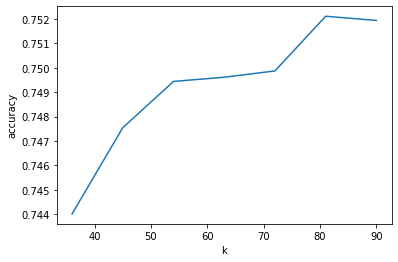

In [ ]:
from matplotlib import pyplot as plt
plt.plot(k_list, acc)
plt.ylabel('accuracy')
plt.xlabel('k')
plt.show()

In [ ]:
test_df = pd.read_csv('test_data_tabular_format.csv')
test_df = test_df.fillna('0')
test_df = replace_hp_percents(test_df)

In [ ]:
to_encode = [units_columns, weapons_columns, armor_columns, gadgets_columns, maps_columns]
for c in to_encode:
  test_df = encode(c, test_df)

test_df = fill_eff(test_df, weapons_effectiveness, weapons_columns)
#test_df = fill_eff(test_df, units_effectiveness, units_columns)
test_df = fill_eff(test_df, armors_effectiveness, armor_columns)
test_df = fill_eff(test_df, gadgets_effectiveness, gadgets_columns)

to_delete = ['id', 'version', 'players.0.player_id', 'players.1.player_id', 'mode']
to_encode = [maps_columns, units_columns]
for c in to_encode:
  to_delete += c

test_df = delete_columns(to_delete, test_df)
test_df = normalization(test_df)
test_df.head()

197
183


,t,turn_no,to_move,teams.0.0.dead,teams.0.0.current_ap,teams.0.0.current_hp,teams.0.0.armor.hp,teams.0.0.armor.id,teams.0.0.weapons_stats.0.id,teams.0.0.weapons_stats.0.cnt,teams.0.0.weapons_stats.1.id,teams.0.0.weapons_stats.1.cnt,teams.0.0.gadgets_stats.0.id,teams.0.0.gadgets_stats.0.cnt,teams.0.0.gadgets_stats.1.id,teams.0.0.gadgets_stats.1.cnt,teams.0.0.gadgets_stats.2.id,teams.0.0.gadgets_stats.2.cnt,teams.0.0.gadgets_stats.3.id,teams.0.0.gadgets_stats.3.cnt,teams.0.0.gadgets_stats.4.id,teams.0.0.gadgets_stats.4.cnt,teams.0.1.dead,teams.0.1.current_ap,teams.0.1.current_hp,teams.0.1.armor.hp,teams.0.1.armor.id,teams.0.1.weapons_stats.0.id,teams.0.1.weapons_stats.0.cnt,teams.0.1.weapons_stats.1.id,teams.0.1.weapons_stats.1.cnt,teams.0.1.gadgets_stats.0.id,teams.0.1.gadgets_stats.0.cnt,teams.0.1.gadgets_stats.1.id,teams.0.1.gadgets_stats.1.cnt,teams.0.1.gadgets_stats.2.id,teams.0.1.gadgets_stats.2.cnt,teams.0.1.gadgets_stats.3.id,teams.0.1.gadgets_stats.3.cnt,teams.0.1.gadgets_stats.4.id,...,teams.1.3.weapons_stats.1.id,teams.1.3.weapons_stats.1.cnt,teams.1.3.gadgets_stats.0.id,teams.1.3.gadgets_stats.0.cnt,teams.1.3.gadgets_stats.1.id,teams.1.3.gadgets_stats.1.cnt,teams.1.3.gadgets_stats.2.id,teams.1.3.gadgets_stats.2.cnt,teams.1.3.gadgets_stats.3.id,teams.1.3.gadgets_stats.3.cnt,teams.1.3.gadgets_stats.4.id,teams.1.3.gadgets_stats.4.cnt,control_points.0.captured,control_points.0.owner,control_points.1.captured,control_points.1.owner,control_points.2.captured,control_points.2.owner,generators.0.0.dead,generators.0.0.hp,generators.0.1.dead,generators.0.1.hp,generators.0.2.dead,generators.0.2.hp,generators.0.3.dead,generators.0.3.hp,generators.0.4.dead,generators.0.4.hp,generators.1.0.dead,generators.1.0.hp,generators.1.1.dead,generators.1.1.hp,generators.1.2.dead,generators.1.2.hp,generators.1.3.dead,generators.1.3.hp,generators.1.4.dead,generators.1.4.hp,players.0.ai,players.1.ai
0,0.041498,0.136364,0.0,0.0,0.046667,0.083333,0.762712,1.000000,0.311164,1.00,0.918782,0.50,0.553325,0.500000,0.644949,0.166667,0.057147,0.166667,0.362498,0.00,0.460198,0.000000,0.0,0.006667,0.083333,0.803571,1.000000,0.311164,1.00,0.835706,0.80,0.553325,0.500000,0.644949,0.166667,0.460324,0.166667,0.362498,0.00,0.460198,...,0.852674,0.40,0.553325,0.500000,0.450712,0.333333,0.381042,0.166667,0.126663,0.50,0.460198,0.0,0.0,0.5,0.0,0.5,0.0,0.5,0.0,0.020833,0.0,0.020833,0.0,0.020833,0.0,0.020202,0.0,0.020833,0.0,0.020833,0.0,0.021505,0.0,0.020202,0.0,0.021277,0.0,0.021505,1.0,1.0
1,0.134691,0.318182,0.0,0.0,0.026667,0.070833,0.000000,0.152825,1.000000,0.20,0.792180,0.40,0.553325,0.500000,0.362498,0.000000,0.362498,0.000000,0.362498,0.00,0.460198,0.000000,0.0,0.140000,0.083333,0.000000,0.152825,0.424313,0.02,0.942384,0.60,0.186185,0.333333,0.186185,0.333333,0.644949,0.333333,0.282501,0.25,0.460198,...,0.807583,0.02,0.186185,0.333333,0.186185,0.333333,0.362498,0.000000,0.362498,0.00,0.460198,0.0,1.0,0.5,1.0,1.0,0.0,0.5,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,1.0,1.0
2,0.044112,0.181818,1.0,0.0,0.013333,0.083333,0.847458,1.000000,0.735684,0.02,0.821137,0.40,0.553325,0.500000,0.282501,0.166667,0.362498,0.000000,0.362498,0.00,0.460198,0.000000,0.0,0.353333,0.083333,0.892857,0.000000,0.760024,0.02,0.762748,0.02,1.000000,0.500000,0.263580,0.166667,0.362498,0.000000,0.362498,0.00,0.460198,...,0.735358,0.50,0.282501,0.166667,1.000000,0.500000,0.460324,0.166667,0.278862,0.25,0.460198,0.0,0.0,0.0,0.0,0.0,1.0,0.5,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,1.0,1.0
3,0.039453,0.000000,1.0,0.0,0.333333,0.083333,0.847458,0.330171,0.136052,0.02,0.924621,0.02,0.206383,0.166667,0.206383,0.166667,0.381042,0.166667,0.487598,0.25,0.460198,0.000000,0.0,0.606667,0.083333,0.357143,0.363997,0.735684,0.02,0.753615,0.02,0.206383,0.166667,0.206383,0.166667,0.278862,0.166667,0.362498,0.00,0.460198,...,0.815

In [ ]:
test_x = np.asarray(test_df)

In [ ]:
model = train(x, y)

Epoch 1/20
605/605 [==============================] - 3s 3ms/step - loss: 0.5370 - binary_accuracy: 0.7201
Epoch 2/20
605/605 [==============================] - 2s 3ms/step - loss: 0.4983 - binary_accuracy: 0.7573
Epoch 3/20
605/605 [==============================] - 2s 3ms/step - loss: 0.4873 - binary_accuracy: 0.7567
Epoch 4/20
605/605 [==============================] - 2s 3ms/step - loss: 0.4791 - binary_accuracy: 0.7643
Epoch 5/20
605/605 [==============================] - 2s 3ms/step - loss: 0.4688 - binary_accuracy: 0.7698
Epoch 6/20
605/605 [==============================] - 2s 3ms/step - loss: 0.4598 - binary_accuracy: 0.7768
Epoch 7/20
605/605 [==============================] - 2s 3ms/step - loss: 0.4611 - binary_accuracy: 0.7757
Epoch 8/20
605/605 [==============================] - 2s 3ms/step - loss: 0.4628 - binary_accuracy: 0.7715
Epoch 9/20
605/605 [==============================] - 2s 3ms/step - loss: 0.4601 - binary_accuracy: 0.7774
Epoch 10/20
605/605 [================

In [ ]:
predictions = model.predict(test_x)